In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score,make_scorer, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [4]:
dataset = fetch_california_housing()

In [5]:
dataset.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['Price'] = dataset.target

In [7]:
df.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
Price,0


In [8]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


In [9]:
X = df.drop('Price', axis = True).values
y = df['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def print_metrics(y_true, y_pred):
    print(f'R2 : {r2_score(y_test, y_pred):.2f}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')


## Random Forest

In [11]:
scores = []
for i in range(10, 30, 5):
    model = RandomForestRegressor(n_estimators=100, max_depth=i,max_features='sqrt', random_state=42 )
    scores.append(np.mean(cross_val_score(model, X_train, y_train, cv = 5 )))

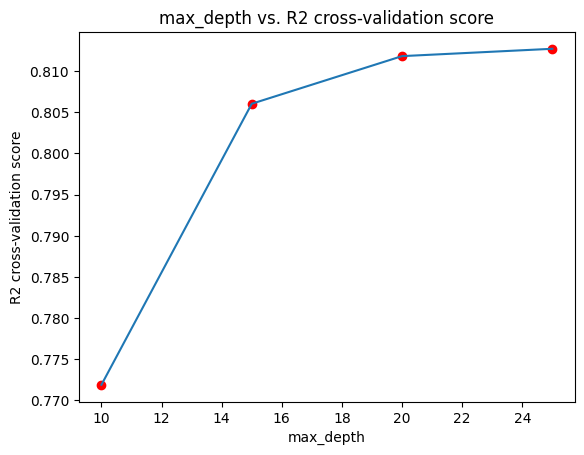

In [12]:
plt.scatter(range(10, 30, 5), scores, c = 'r')
plt.plot(range(10, 30, 5), scores)
plt.title('max_depth vs. R2 cross-validation score')
plt.xlabel('max_depth')
plt.ylabel('R2 cross-validation score')
plt.show()

In [13]:
model = RandomForestRegressor(n_estimators=500, max_depth=25,max_features='sqrt', random_state=42 )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [14]:
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

R2 : 0.81
MAE: 0.33
MSE: 0.24


## XGBoost

In [47]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=make_scorer(r2_score),
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


print("Best R²:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best R²: 0.8467835339783626
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


In [22]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=3,
    n_jobs=-1,
    random_state=42
)

In [23]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

R2 : 0.86
MAE: 0.28
MSE: 0.19


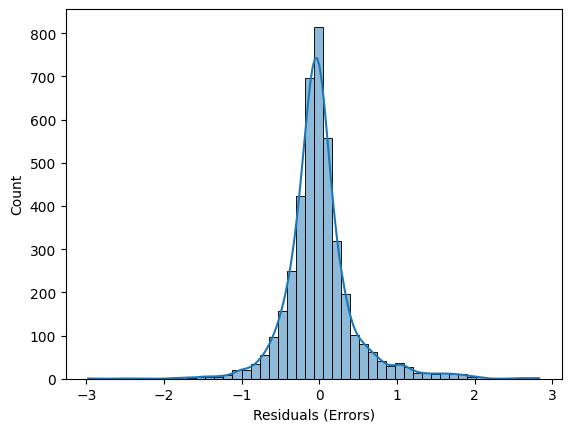

In [24]:
import seaborn as sns
residuals = y_test - model.predict(X_test)
sns.histplot(residuals, bins = 50, kde = True)
plt.xlabel('Residuals (Errors)')
plt.show()

## Catboost

In [27]:
model = CatBoostRegressor(
      iterations = 1000,
      learning_rate= 0.05,
      depth = 10, verbose=1000,
      l2_leaf_reg=3,
      random_seed=42,
      early_stopping_rounds=50)
print(f'Cross validation  score: {np.mean(cross_val_score(model, X_train, y_train, cv = 5 )):.4f}')

0:	learn: 1.1168163	total: 65.2ms	remaining: 1m 5s
999:	learn: 0.2240094	total: 32.2s	remaining: 0us
0:	learn: 1.1246856	total: 49.5ms	remaining: 49.4s
999:	learn: 0.2211968	total: 31.9s	remaining: 0us
0:	learn: 1.1207905	total: 28.8ms	remaining: 28.8s
999:	learn: 0.2284749	total: 35.4s	remaining: 0us
0:	learn: 1.1240879	total: 28.8ms	remaining: 28.8s
999:	learn: 0.2273763	total: 32.8s	remaining: 0us
0:	learn: 1.1172072	total: 28.5ms	remaining: 28.5s
999:	learn: 0.2246185	total: 30.9s	remaining: 0us
Cross validation  score: 0.8504


In [28]:
model.fit(X_train, y_train)

0:	learn: 1.1206400	total: 39.8ms	remaining: 39.7s
999:	learn: 0.2421835	total: 31.2s	remaining: 0us


In [29]:
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

R2 : 0.85
MAE: 0.29
MSE: 0.19


## ANN (Artificial Neural network)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit( X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,callbacks=[early_stop],verbose=1)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5299 - mae: 0.8610 - val_loss: 0.4271 - val_mae: 0.4666
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4028 - mae: 0.4433 - val_loss: 0.4058 - val_mae: 0.4534
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3536 - mae: 0.4200 - val_loss: 0.4301 - val_mae: 0.4389
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3501 - mae: 0.4102 - val_loss: 0.3613 - val_mae: 0.4130
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3213 - mae: 0.3926 - val_loss: 0.3516 - val_mae: 0.3969
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3243 - mae: 0.3903 - val_loss: 0.3416 - val_mae: 0.4066
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3203 - mae: 0.3827 - val_loss: 0.3703 - val_mae: 0.4017
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3132 - mae: 0.3811 - val_loss: 0.3373 - val_mae: 0.3991
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [45]:
print(r2_score(y_train, model.predict(X_train)))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8386544709145193


In [46]:
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R2 : 0.80
MAE: 0.34
MSE: 0.26
